In [168]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt

### Load excel file

In [6]:
df = pd.read_excel("Superstore.xls")
df.head()

Row ID        Order ID Order Date  Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156 2016-11-08 2016-11-11    Second Class    CG-12520   
1       2  CA-2016-152156 2016-11-08 2016-11-11    Second Class    CG-12520   
2       3  CA-2016-138688 2016-06-12 2016-06-16    Second Class    DV-13045   
3       4  US-2015-108966 2015-10-11 2015-10-18  Standard Class    SO-20335   
4       5  US-2015-108966 2015-10-11 2015-10-18  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID         Category Sub-Category  \
0       42420   South  FUR-BO-10001798        Furniture    Bookcases   
1       42420   South  FUR-CH-10000454        Furniture       Chairs   
2       90036    West  OFF-LA-10000240  Office Supplies       Labels   
3       33311   South  FUR-TA-10000577        Furniture       Tables   
4       33311   South  OFF-ST-10000760  Office Supplies      Storage   

                                        Product Name     Sales  Quantity  \
0                  Bush Somerset Collection Bookcase  261.9600         2   
1  Hon Deluxe Fabric Upholstered Stacking Chairs,...  731.9400         3   
2  Self-Adhesive Address Labels for Typewriters b...   14.6200         2   
3      Bretford CR4500 Series Slim Rectangular Table  957.5775         5   
4                     Eldon Fold 'N Roll Cart System   22.3680         2   

   Discount    Profit  
0      0.00   41.9136  
1      0.00  219.5820  
2      0.00    6.8714  
3      0.45 -383.0310  
4      0.20    2.5164  

[5 rows x 21 columns]

### Using the ProfileReport of Pandas to get an overview of the data and help understand the data clearly

In [9]:
df_check = ProfileReport(df)
df_check.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Data Preparation
#### Removing columns do not needed and sum all sales by months

In [38]:
df_sales = df[["Order Date", "Sales"]].set_index('Order Date')
df_sales = df_sales.resample('MS').mean()
df_sales.head()

Sales
Order Date            
2014-01-01  180.213861
2014-02-01   98.258522
2014-03-01  354.719803
2014-04-01  209.595148
2014-05-01  193.838418

### Visualizing total sales time series data

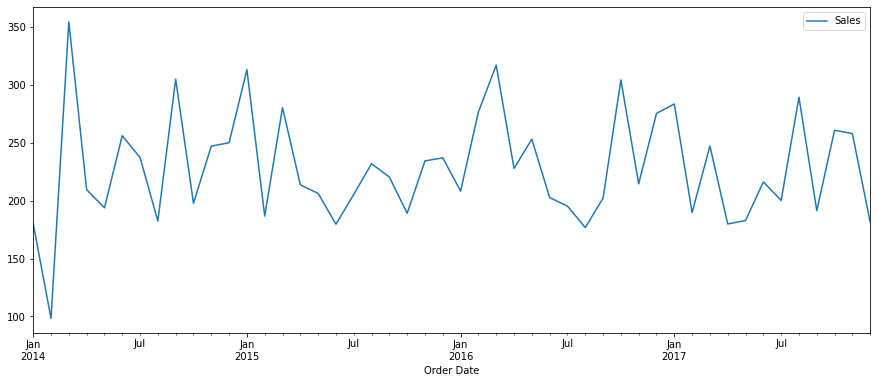

In [39]:
%matplotlib inline
df_sales.plot(figsize=(15, 6))
plt.show()

### In time series there is often a seasonal element.  The forecasting model will be more accurate if the cycle and seasonal pattern are discovered. We can quickly identify them through the graph. A technique known as time-series decomposition, which enables us to divide our time series into three different parts: trend, seasonality, and noise, also enables us to display our data and identify it is seasonal or not.

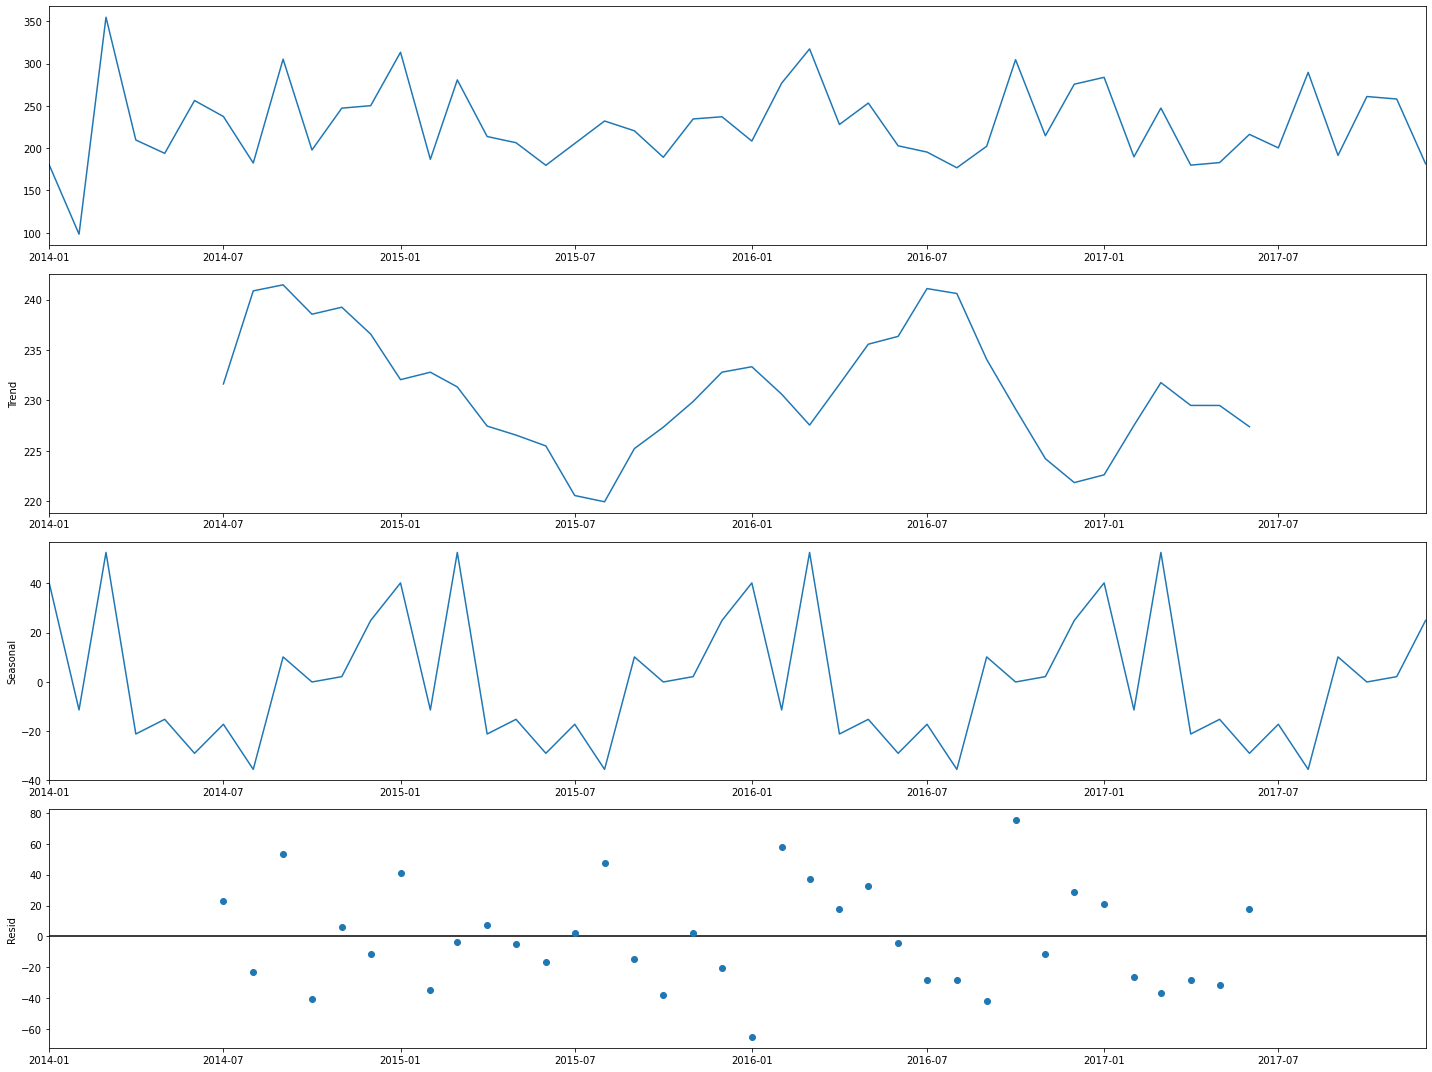

In [47]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 20, 15
decomposition = sm.tsa.seasonal_decompose(df_sales, model='additive')
fig = decomposition.plot()
plt.show()

=> The plot above clearly shows that the sales of furniture is unstable, along with its obvious seasonality.

## Time series forecasting with ARIMA (AutoRegressive Integrated Moving Average).
### In this project, it will be SARIMA (Seasonal AutoRegressive Integrated Moving Average)

#### Split data into training and testing for evaluation later

In [208]:
train, test = df_sales[df_sales.index < '2017-01-01'], df_sales[df_sales.index >= '2017-01-01']
print('train shape: ', train.shape)
print('test shape: ', test.shape)

train shape:  (36, 1)
test shape:  (12, 1)


### SARIMA models denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data. So, i using auto_arima to find the optimal set of parameters that yields the best performance for our model SARIMA

In [209]:
from pmdarima.arima import auto_arima
model = auto_arima(train, start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

print(model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=270.463, Time=0.09 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=269.454, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=272.215, Time=0.19 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=272.120, Time=0.25 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=267.680, Time=0.03 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=270.463, Time=0.14 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=272.463, Time=0.16 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=271.384, Time=0.07 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=271.341, Time=0.07 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.19 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12]          
Total fit time: 1.194 seconds
267.67976014112685


=> The above output suggests that SARIMAX(0, 0, 0)(0, 1, 0, 12) yields the lowest AIC value of 267.68. Therefore we should consider this to be optimal option 

In [225]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   36
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -132.840
Date:                  Wed, 01 Feb 2023   AIC                            267.680
Time:                          21:37:32   BIC                            268.858
Sample:                      01-01-2014   HQIC                           267.992
                           - 12-01-2016                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3758.4679   1212.892      3.099      0.002    1381.244    6135.692
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 0.45
Prob(Q):                              0.79   Prob(JB):                         0.80
Heteroskedasticity (H):               0.53   Skew:                             0.23
Prob(H) (two-sided):                  0.38   Kurtosis:                         2.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Fitting the SARIMA model 

In [210]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(0,0,0),
                                seasonal_order=(0,1,0,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3151.1201   1078.455      2.922      0.003    1037.387    5264.853


### Run model diagnostics to investigate any unusual behavior

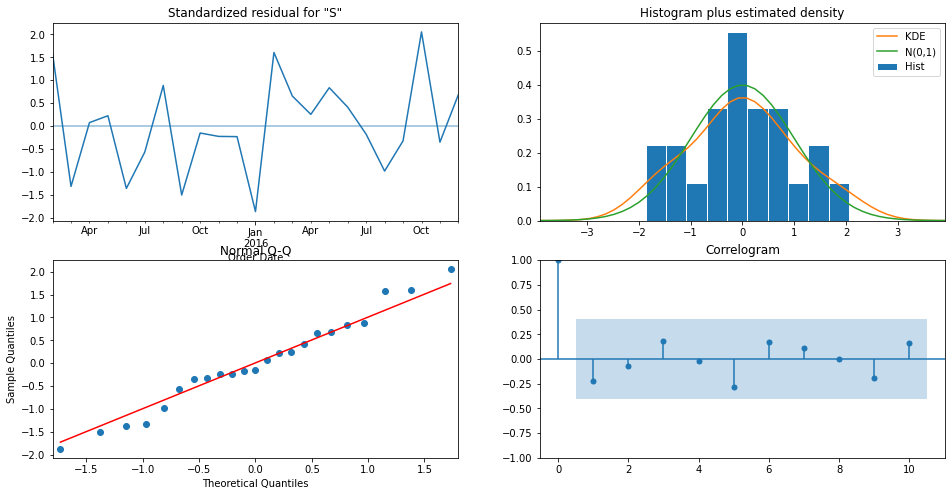

In [211]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

### After having found the best ARIMA model. We will use training set to forecast for the next period. Period is 12 months, corresponding to 12 months of the testing set

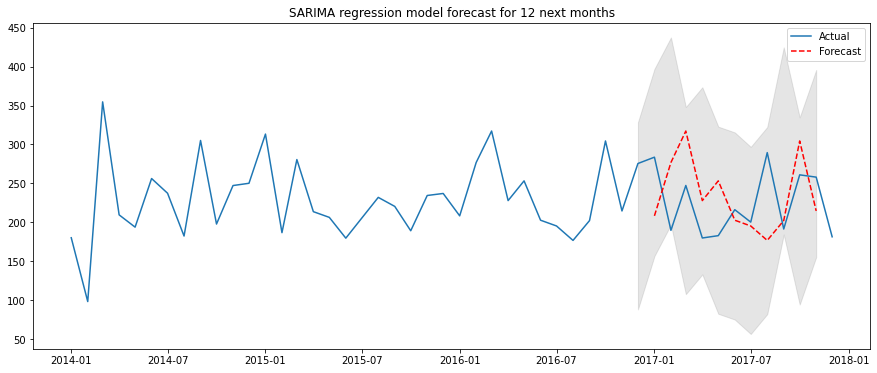

In [213]:
n_pred_perious = 12
fitted, confint = model.predict(n_periods=n_pred_perious, return_conf_int=True)
date = pd.date_range(train.index[-1], periods=n_pred_perious, freq='MS')

fitted_seri = pd.Series(fitted, index=date)
lower = confint[:, 0]
upper = confint[:, 1]

plt.figure(figsize=(15, 6))
plt.plot(df_sales, label='Actual')
plt.plot(fitted_seri, color='red', linestyle='--', label = 'Forecast')
plt.fill_between(date, 
                 lower, 
                 upper,
                 color='grey', alpha=0.2)
plt.legend()
plt.title('SARIMA regression model forecast for 12 next months')
plt.show()

### Evaluation
	- A measure of an estimator's quality is the MSE (Mean Square Error). It is never negative and the smaller the MSE, the closer we are to finding the line of best fit. 
	- Root Mean Square Error (RMSE), our model was able to predict the test set's average daily sales within 63.62 of the actual sales. Our daily sales range between 100 and 360. In my opinion, this is a pretty good model so far.
    - The error between the predicted value and the actual value is 16% of the actual value

In [214]:
def _measure_metric(y, yhat):
  e = y-yhat
  mse=np.mean(e**2)
  rmse=np.sqrt(mse)
  mae=np.mean(np.abs(e))
  mape=np.mean(e/y)

  print('Mean Square Error: {}'.format(mse))
  print('Root Mean Square Error: {}'.format(rmse))
  print('Mean Absolute Error: {}'.format(mae))
  print('Mean Absolute Percentage Error: {}'.format(mape))
  return mse, rmse, mae, mape

mse, rmse, mae, mape=_measure_metric(test.values[0], fitted)


Mean Square Error: 4047.8107252160985
Root Mean Square Error: 63.62240741449587
Mean Absolute Error: 54.79946933414114
Mean Absolute Percentage Error: 0.16119024275104935
